In [10]:
import numpy as np
from scipy import sparse as sp
from matplotlib import pyplot as plt
from IPython.display import clear_output
from matplotlib.colors import LinearSegmentedColormap

In [11]:
h_0 = 0.1
l_x = 10
l_y = 10
d = 12
ħ = 1
m = 1
U_0 = 50

n_x = int(np.round(l_x / h_0))
n_y = int(np.round(l_y / h_0))

h_x = l_x / n_x
h_y = l_y / n_y

x = np.linspace(h_x / 2, l_x - h_x / 2, n_x)
y = np.linspace(h_y / 2, l_y - h_y / 2, n_y)

X, Y = np.meshgrid(x, y, indexing='ij')

In [12]:
def L_csr(n_x, n_y, h_x, h_y, U_0):
    k = np.arange(n_x * n_y, dtype=int).reshape((n_x, n_y))

    left_boundary = l_x - d / 2
    right_boundary = d / 2

    U = np.zeros((n_x, n_y))
    for i in range(n_x):
        for j in range(n_y):
            if left_boundary <= i * h_x <= right_boundary:
                U[i, j] = U_0

    iB = k[:-1, :].flatten()  
    iT = k[1:, :].flatten()  # имеет верхних соседей
    iNB = k[-1, :].flatten()  # никаких соседей снизу
    iNT = k[0, :].flatten()  # никаких соседей сверху
    iR = k[:, :-1].flatten()  # имеет правых соседей
    iL = k[:, 1:].flatten()  # имеет левых соседей
    iNR = k[:, -1].flatten()  # никаких соседей справа
    iNL = k[:, 0].flatten()  # никаких соседей слева
    iC = np.arange(n_x * n_y)

    V1 = (ħ ** 2 / (2 * m)) * (2 / h_x ** 2 + 2 / h_y ** 2) + U.flatten()

    R1, C1, V1 = iC, iC, V1
    R2, C2, V2 = iL, iR, np.full(iL.size, (ħ ** 2 / (2 * m)) * (-1.0 / h_x ** 2))
    R3, C3, V3 = iR, iL, np.full(iR.size, (ħ ** 2 / (2 * m)) * (-1.0 / h_x ** 2))
    R4, C4, V4 = iB, iT, np.full(iB.size, (ħ ** 2 / (2 * m)) * (-1.0 / h_y ** 2))
    R5, C5, V5 = iT, iB, np.full(iT.size, (ħ ** 2 / (2 * m)) * (-1.0 / h_y ** 2))
    R6, C6, V6 = iNR, iNR, np.full(iNR.size, (ħ ** 2 / (2 * m)) * (1.0 / h_x ** 2))
    R7, C7, V7 = iNL, iNL, np.full(iNL.size, (ħ ** 2 / (2 * m)) * (1.0 / h_x ** 2))
    R8, C8, V8 = iNB, iNB, np.full(iNB.size, (ħ ** 2 / (2 * m)) * (1.0 / h_y ** 2))
    R9, C9, V9 = iNT, iNT, np.full(iNT.size, (ħ ** 2 / (2 * m)) * (1.0 / h_y ** 2))

    row = np.concatenate((R1, R2, R3, R4, R5, R6, R7, R8, R9))
    col = np.concatenate((C1, C2, C3, C4, C5, C6, C7, C8, C9))
    val = np.concatenate((V1, V2, V3, V4, V5, V6, V7, V8, V9))

    return sp.csr_matrix((val, (row, col)))

In [13]:
def μ_L(y):
  return 0


def μ_R(y):
  return 0


def μ_B(x):
  return 0


def μ_T(x):
  return 0

In [14]:
H = L_csr(n_x, n_y, h_x, h_y, U_0)


def crank_nicolson_step(ψ, H, τ, ν ):
    E = sp.eye(n_x * n_y, format='csr')
    A = E + 1j * (τ * ν / ħ) * H
    B = E - 1j * (τ * (1 - ν) / ħ) * H

    ψ = sp.linalg.spsolve(A, B @ ψ)
    return ψ

In [15]:
def initial_wave_packet(x, y, x_0, y_0, kx, ky, ε):
    r = np.sqrt((x - x_0) ** 2 + (y - y_0) ** 2)
    a = np.where(r < ε, np.cos(np.pi * r / (2 * ε)) ** 3, 0)
    return a * np.exp(1j * (kx * x + ky * y))


x_0, y_0 = 2, 5
kx, ky = 10, 0
ε = 2.5

ψ_initial = initial_wave_packet(X, Y, x_0, y_0, kx, ky, ε)

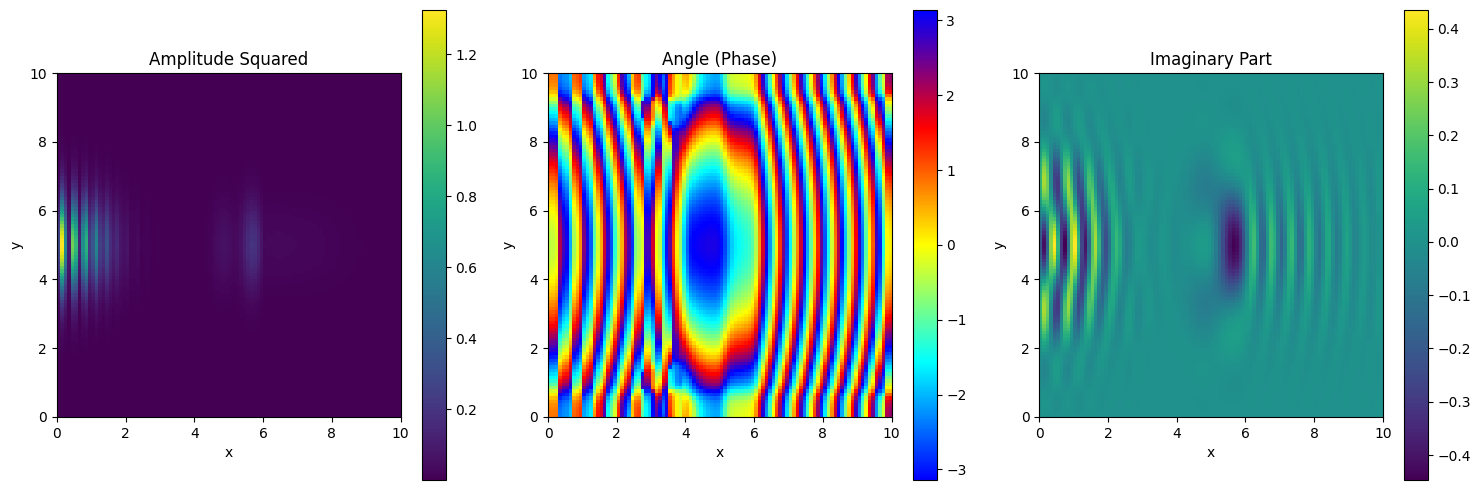

In [16]:
ν = 0.5
T = 0.9
τ = 0.01
num_time_steps = int(T / τ)

ψ_n = ψ_initial.flatten()

drawing_pause = 2

colors = ['blue', 'cyan', 'yellow', 'red', 'blue']
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

for t in range(num_time_steps):
    ψ_n = crank_nicolson_step(ψ_n, H, τ, ν)
    if t % drawing_pause == 0:
        clear_output(True)

        fig, axs = plt.subplots(1, 3, figsize=(15, 5))

        im1 = axs[0].imshow(np.abs(ψ_n.reshape((n_x, n_y)).T)**2, extent=(0, l_x, 0, l_y))
        axs[0].set_title('Amplitude Squared')
        axs[0].set_xlabel('x')
        axs[0].set_ylabel('y')
        fig.colorbar(im1, ax=axs[0])

        im2 = axs[1].imshow(np.angle(ψ_n.reshape((n_x, n_y))).T, extent=(0, l_x, 0, l_y), cmap=cmap)
        axs[1].set_title('Angle (Phase)')
        axs[1].set_xlabel('x')
        axs[1].set_ylabel('y')
        fig.colorbar(im2, ax=axs[1])

        im3 = axs[2].imshow(ψ_n.reshape((n_x, n_y)).imag.T, extent=(0, l_x, 0, l_y))
        axs[2].set_title('Imaginary Part')
        axs[2].set_xlabel('x')
        axs[2].set_ylabel('y')
        fig.colorbar(im3, ax=axs[2])

        plt.tight_layout()
        plt.show()